# Characterizing passive properties of cells from intracellular recordings

In [6]:
import os, sys
import numpy as np
from analyz.IO.igor import load_hdf5_exported_from_Igor as load_data
%matplotlib inline
from datavyz import gen as ge

## I) From Voltage-Clamp data

### I-1) Theoretical analysis

Solving the membrane equation with a resistance in series to the amplifier

(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f3f8eae1350>)

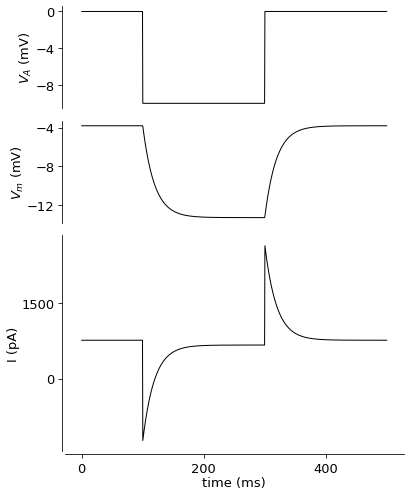

In [2]:
def current_response_to_VC_step(t, Rm=100e6, Cm=200e-12, Rs=5e6, El=-80e-3,
                                t0=50e-3, t1=250e-3, VCstep=-5e-3,
                                VA0=0e-3):
    """
    current response to voltage-clamp pulse 
    --> all parameters should be SI units !!
    """
    VA = VA0+(np.sign(t-t0)-np.sign(t-t1))                                                             /2.*VCstep # amplifier potential
    Vm0 = (VA0*Rm+El*Rs)/(Rm+Rs)
    Tau = Rm*Cm/(1+Rs/Rm)

    Vm = 0*t    
    cond0 = t<t0
    Vm[cond0] = Vm0
    cond1 = (t>=t0) & (t<=t1)
    Vm[cond1] = Vm0+Rm/(Rm+Rs)*VCstep*(1-np.exp(-(t[cond1]-t0)/Tau))
    cond2 = (t>t1)
    Vm[cond2] = Vm0+Rm/(Rm+Rs)*VCstep*np.exp(-(t[cond2]-t1)/Tau)
    return VA, Vm, (VA-Vm)/Rs

t = np.linspace(0, 500e-3, 1000)

Va, Vm, Ia = current_response_to_VC_step(t, VCstep=-10e-3, t0=100e-3, t1=300e-3)
fig, AX = ge.figure(axes_extents=[[[2,1]],[[2,1]],[[2,2]]], hspace=0.2, figsize=(.9,.9))
ge.plot(1e3*t, 1e3*Va, ax=AX[0], axes_args=dict(spines=['left'], ylabel='$V_A$ (mV)'))
ge.plot(1e3*t, 1e3*Vm, ax=AX[1], axes_args=dict(spines=['left'], ylabel='$V_m$ (mV)'))
ge.plot(1e3*t, 1e12*Ia, ax=AX[2], axes_args=dict(xlabel='time (ms)', ylabel='I (pA)'))

### I-2) Experimental characterization

In [3]:
from scipy.optimize import minimize

def step(t, t0, t1):
    return (np.sign(t-t0)-np.sign(t-t1))/2.

def heaviside(t, t1):
    return (np.sign(t-t1)+1)/2.

def func_to_fit(t, coeffs, t0=50, t1=150):
    Ibsl, IbslShift, IexpComp, Tau = coeffs
    return Ibsl+\
        step(t, t0, t1)*(-IbslShift-IexpComp*np.exp(-(t-t0)/Tau))+\
        heaviside(t, t1)*IexpComp*np.exp(-(t-t1)/Tau)


def extract_charact(t, data, t0=50, t1=300,
                    with_plot=False):
    
    TforBaseline = [t0-(t1-t0)/3., t0] 
    TforBaselineShift = [t1-(t1-t0)/3., t1] 
    TforPeak = [t0, t0+(t1-t0)/3.] 
    Ibsl = data[(t>TforBaseline[0])&(t<TforBaseline[1])].mean()
    IbslShift = np.abs(data[(t>TforBaselineShift[0]) & (t<TforBaselineShift[1])].mean()-Ibsl)
    IexpPeak = np.max(np.abs(data[(t>TforPeak[0]) & (t<TforPeak[1])]-Ibsl))

    def to_minimize(coefs):
        return np.mean(np.abs(data-func_to_fit(t, coefs, t0=t0, t1=t1)))
    
    res = minimize(to_minimize,
                   [1,1,1,1], method='SLSQP', bounds=[(0,np.inf) for i in range(4)])
    Tau = res.x[3]

    if with_plot:
        fig, ax = ge.plot(t, data, fig_args={'figsize':(1.5,1.5)}, label='VC-data')
        ax.plot([t[0], t[-1]], Ibsl*np.ones(2), ':', lw=1, label='$I_{bsl}$')
        ax.plot([t[0], t[-1]], (Ibsl-IbslShift)*np.ones(2), ':', lw=1, label='$I_{bsl}^{shift}$')
        ax.plot([t[0], t[-1]], (Ibsl-IexpPeak)*np.ones(2), ':', lw=1, label='$I_{exp}^{peak}$')
        ax.plot(t0*np.ones(2), ax.get_ylim(), ':', lw=1, label='$t_0$')
        ax.plot(t1*np.ones(2), ax.get_ylim(), ':', lw=1, label='$t_1$')
        ax.plot(t, func_to_fit(t, res.x, t0=t0, t1=t1), 'w--', lw=0.5, label='fit for $\\tau$')
        ge.legend(ax, loc=(1.,0.))
        return fig, ax, IbslShift, IexpPeak, Tau
    else:
        return IbslShift, IexpPeak, Tau

def from_charact_to_membrane_parameters(IbslShift, IexpPeak, Tau,
                                        Vstep=5e-3, verbose=False):
    Rs = np.abs(Vstep)/IexpPeak
    C = Rs*IbslShift/np.abs(Vstep)
    Rm = Rs*(1-C)/C
    Cm = Tau*(Rm+Rs)/Rm/Rs
    if verbose:
        print("""
        membrane and recording parameters:
        - Rm=%.1fMOhm
        - Cm=%.1fpF
        - Rs=%.1fMOhm
        """ % (1e-6*Rm, 1e12*Cm, 1e-6*Rs))
    return Rm, Cm, Rs


In [4]:
fn = '/media/yann/Windows/Users/yann.zerlaut/Documents/DATA/Data_Nunzio/2019/September/nm18Sep2019c1/nm18Sep2019c1_000.h5'
Data = load_data(fn)


        membrane and recording parameters:
        - Rm=59.3MOhm
        - Cm=396.3pF
        - Rs=12.7MOhm
        


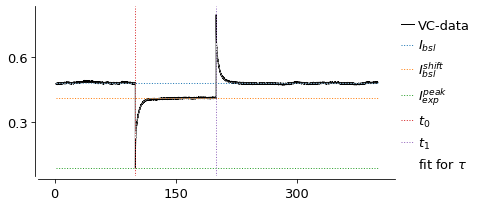

In [5]:
t = Data['t']
tcond = (t>2) & (t<400)
trace = Data['recordings']['Irecording'].mean(axis=0)
_,_,IbslShift, IexpPeak, Tau = extract_charact(t[tcond], trace[tcond], t0=100, t1=200, with_plot=True)
_ = from_charact_to_membrane_parameters(1e-9*IbslShift, 1e-9*IexpPeak, 1e-3*Tau, verbose=True)

## II) From current-clamp data